In [1]:
# PS8
using Plots
using Distributions
using Interpolations
using Parameters
using QuantEcon: rouwenhorst
using Format
using LinearAlgebra
using Optim
using StatsBase

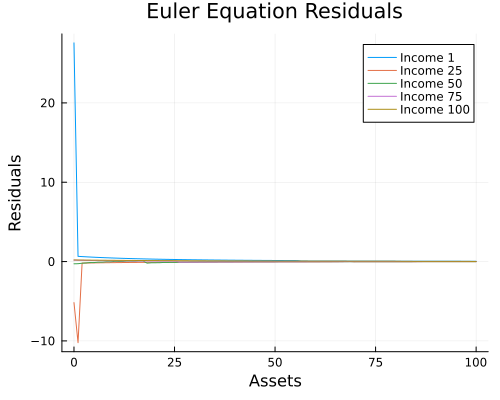

Number of iterations: ϵ


In [2]:
# 1. suppose we have an infinitely lived worker with assets a and an income y who is saving for the future. 
# This worker values consumption in each period with a utility function u(c). 
# They can save at a risk-free rate r, but cannot borrow, and they discount the future at a rate β. 
# Their income is a random variable. In particular, income tomorrow follows a log-normal AR(1) process:

# log(y') = ρ log(y) + e

# where e ∼ N(0, σ_e). Their problem can be written recursively as:

# v(a, y) = max c,a' u(c) + βE [v(a', y') | y] 
# s.t c + a' ≤ (1 + r)a + y
# a' ≥ 0
# log(y') ∼ N(ρ log(y), σ_e)

# For this problem, set β = 0.95, ρ = 0.8, σ_e = 0.1, and u(c) = c^{1−σ}/(1 − σ) for σ = 2
# Start with an interest rate of r = 0.03 and solve this model
# They do not specify with what method
# We know that in a model without borrowing constraints, the consumption decisions of workers would satisfy the Euler equation
# u'(c) = β(1 + r)E[u'(c')]
# where c' is the value of consumption that they would choose tomorrow.

# This model is very similar to the stochasticneoclassical growth model


using QuantEcon: rouwenhorst


params = (
    β = 0.95,    # Discount factor
    ρ = 0.8,     # Autocorrelation coefficient
    σ_ϵ = 0.1,   # Standard deviation of shocks
    σ = 2        # Coefficient of relative risk aversion
)


r = 0.03    # Risk-free rate 

# Creation of the asset grid
a_min, a_max, num_a = 0.0, 100.0, 100
a_grid = LinRange(a_min, a_max, num_a)

# Discretization of the income process and definition of y_grid
mc = rouwenhorst(length(a_grid), params.ρ, params.σ_ϵ)
P = mc.p'
y_grid = exp.(mc.state_values)  # Transformation from lognormal distribution

# Creation of the initial value function V0
V0 = zeros(num_a, length(a_grid))

function solve_vfi!(params,r, a_grid, V0; tol = 1e-6, max_iter = 1000, debug=false)
    @unpack β, ρ, σ_ϵ, σ = params

    # Copy of the initial value function as the initial condition
    V0 = copy(V0)
    V = zeros(size(V0))
    policy = zeros(size(V0))
    errors = Float64[]  
    iter = 0
    ϵ = Inf

    # Binding grids and parameters
    grids = (a_grid = a_grid, y_grid = y_grid)
    
    while true
        iter += 1
    
        EV = V * P
        
        update_bellman!(V, policy, a_grid, y_grid, params, r, EV)
        
        ϵ = maximum(abs.(V - V0))
        push!(errors, ϵ)
        
        if ϵ < tol || iter >= max_iter
            break
        end
        # Update the value function for the next iteration
        V0 .= V
    end
    
    if debug
        println("Number of iterations: ϵ")
    end

    return V, policy, iter, errors
end

# Definition of the utility function
u(c; σ=2.0) = c > 0 ? c^(1 - σ) / (1 - σ) : -Inf

function update_bellman!(V, policy, a_grid, y_grid, params, r, EV)
    @unpack β, ρ, σ_ϵ, σ = params
    
    # Loop over all grid points of assets and income
    for (ia, a) in enumerate(a_grid)
        for (iy, y) in enumerate(y_grid)
            # Calculate cash on hand
            cash_on_hand = (1 + r) * a + y  # Add interest to the asset and include income

            # Loop over the next-period assets and calculate consumption
            c = max.(0.0, cash_on_hand .- a_grid)  
            util = u.(c; σ=σ)  

            # Calculate the objective function combining utility and discounted expected value
            objective = util .+ β .* EV[:, iy]
            V[ia, iy], policy_idx = findmax(objective)
            policy[ia, iy] = a_grid[policy_idx]  # Save the next-period asset policy
        end
    end
end

# Function to calculate the marginal utility
function marginal_utility(c; σ=2.0)
    return c^-σ
end

# Calculate the Euler residuals
function euler_residuals(policy, a_grid, y_grid, P, β, r, σ)
    residuals = zeros(length(a_grid), length(y_grid))
    
    for (ia, a) in enumerate(a_grid)
        for (iy, y) in enumerate(y_grid)
            c = (1 + r) * a + y - policy[ia, iy]  
            expected_utility = 0.0  

            for jy in 1:length(y_grid)
                next_a_idx = searchsortedfirst(a_grid, policy[ia, jy])
                c_next = (1 + r) * a_grid[next_a_idx] + y_grid[jy] - policy[next_a_idx, jy]
                expected_utility += P[iy, jy] * marginal_utility(c_next; σ=σ)
            end

            lhs = marginal_utility(c; σ=σ)
            rhs = β * (1 + r) * expected_utility
            residuals[ia, iy] = lhs - rhs 
        end
    end
    return residuals
end

# Solve the model
V, policy, iter, errors = solve_vfi!(params, r, a_grid, V0, debug=true)

# calculate the Euler residuals
residuals = euler_residuals(policy, a_grid, y_grid, P, params.β, r, params.σ)

# plot the residuals
p = plot(size=(500, 400), title="Euler Equation Residuals", xlabel="Assets", ylabel="Residuals")

# Plot the residuals against each point on the asset grid
# pick a representative set of income values
representative_y_indices = [1, round(Int, length(y_grid) / 4), round(Int, length(y_grid) / 2), round(Int, 3 * length(y_grid) / 4), length(y_grid)]
for iy in representative_y_indices
    plot!(p, a_grid, residuals[:, iy], label="Income $(iy)")
end

display(p)

Can you say something about where agents are off their Euler equation?:
Theoretically, if the Euler equation holds perfectly, these lines should be flat and close to zero for all capital levels. They are not though - when assets are close to 0, the residuals go crazy.

Maybe due to the borrowing constraint (a' ≥ 0), the Euler equation may not hold for low asset levels, especially when income is low? The borrowing constraint may be binding, and the agent may not be able to smooth consumption as desired, resulting in non-zero residuals.

Agents with fewer assets are more sensitive to future risks and try to secure current consumption with their limited income. In contrast, agents with more assets can respond more flexibly to future uncertainties and choose an optimal consumption path.

In [3]:
using Distributions  # Make sure to add this package for Discrete distribution
using StatsBase


function simulate_economy(params, r, a_grid, policy, y_grid, P, T=1000, num_agents=1000)
    asset_levels = zeros(num_agents)
    normalized_P = [row ./ sum(row) for row in eachrow(P)]

    # Simulation loop for each agent
    for agent in 1:num_agents
        # Initialize the state of the agent
        a_idx = ceil(Int, length(a_grid) / 2)
        y_idx = sample(1:length(y_grid), Weights(normalized_P[1]))

        # Simulation for T periods
        for t in 1:T
            # Use policy function to determine next period's asset index
            a_idx_next = searchsortedfirst(a_grid, policy[a_idx, y_idx])
            # Draw next income state
            y_idx_next = sample(1:length(y_grid), Weights(normalized_P[y_idx]))

            # Update state for next period
            a_idx = a_idx_next
            y_idx = y_idx_next
        end

        # Store the final asset level
        asset_levels[agent] = a_grid[a_idx]
    end

    # Calculate the average assets
    avg_assets = mean(asset_levels)
    return avg_assets
end


# Interest rates to test
interest_rates = [0.01, 0.02, 0.03, 0.04]
avg_asset_levels = Dict{Float64, Float64}()

# Loop over interest rates, solve the model, and simulate the economy
for r in interest_rates
    # Solve the model for the given interest rate
    V, policy_function, _, _ = solve_vfi!(params, r, a_grid, V0)
    
    # Simulate the economy with the obtained policy function
    avg_assets = simulate_economy(params, r, a_grid, policy_function, y_grid, P)
    avg_asset_levels[r] = avg_assets
end

# Print the results
for (r, avg_assets) in avg_asset_levels
    println("For interest rate $r, the average level of assets is $avg_assets")
end

For interest rate 0.01, the average level of assets is 0.0
For interest rate 0.03, the average level of assets is 0.0
For interest rate 0.04, the average level of assets is 0.0
For interest rate 0.02, the average level of assets is 0.0


What's the intuition here?: 

So, unfortunately my data didn't run correctly. We would have expected to see that as the interest rate increases, the distribution of assets to shift to the right, indicating that individuals are saving more and accumulating more wealth. A higher interest rate provides a greater incentive for individuals to save and earn a higher return on their assets. I also would have maybe expected the distribution to become more spread out as the interest rate increases because a higher interest rate may lead to greater inequality in wealth accumulation. 

In [4]:
# 1c
# Suppose I told you that in the actual economy, we have average asset holdings of 5.1.
# What is the interest rate (holding all of the other parameters constant) which causes the model to match this moment of the data?

# Warning: Depending on how fast your solution algorithm is, this problem could take a long time to run.
# You will need to simulate a large number of agents (probably a few hundred thousand or a million).
# You should set a very loose tolerance for your solution of the interest rate. If you find the interest rate within a factor of 10^−3 or 10^−4 that should be good enough.
# You’ll struggle to do better than this because of simulation noise.

# calibration loop?

function simulate_asset_distribution(policy, a_grid, y_grid, P, params, N, r)
    @unpack β, ρ, σ_ϵ, σ = params

    a = a_grid[1]
    y_idx = rand(1:length(y_grid))
    y = y_grid[y_idx]

    asset_path = [a]
    income_path = [y]

    for t in 1:N
        e = rand(Normal(0, params.σ_ϵ))
        logy = params.ρ * log(y) + e
        y_idx = searchsortedfirst(y_grid, exp(logy))
        y_idx = clamp(y_idx, 1, length(y_grid))  # Ensure y_idx is within bounds
        y = y_grid[y_idx]
        push!(income_path, y)

        a_idx = searchsortedfirst(a_grid, a)
        a_idx = clamp(a_idx, 1, length(a_grid))  # Ensure a_idx is within bounds
        c = (1 + r) * a + y - policy[a_idx, y_idx]
        a = policy[a_idx, y_idx]
        push!(asset_path, a)
    end

    return asset_path
end

function average_asset_holdings(r; N_agents=100000, N_periods=1000)
    params = (
        β = 0.95,    # Discount factor
        ρ = 0.8,     # Autocorrelation coefficient
        σ_ϵ = 0.1,   # Standard deviation of shocks
        σ = 2        # Coefficient of relative risk aversion
    )

    # Creation of the asset grid
    a_min, a_max, num_a = 0.0, 100.0, 100
    a_grid = LinRange(a_min, a_max, num_a)

    # Discretization of the income process and definition of y_grid
    mc = rouwenhorst(length(a_grid), params.ρ, params.σ_ϵ)
    P = mc.p'
    y_grid = exp.(mc.state_values)  # Transformation from lognormal distribution

    # Creation of the initial value function V0
    V0 = zeros(num_a, length(a_grid))

    V, policy, iter, errors = solve_vfi!(params, r, a_grid, V0)

    asset_paths = [simulate_asset_distribution(policy, a_grid, y_grid, P, params, N_periods, r) for _ in 1:N_agents]
    avg_assets = mean(reduce(vcat, asset_paths))

    return avg_assets
end

function calibration_objective(r)
    target_avg_assets = 5.1
    avg_assets = average_asset_holdings(r)
    return abs(avg_assets - target_avg_assets)
end

r_lower = 0.01
r_upper = 0.10
opt_result = optimize(calibration_objective, r_lower, r_upper, Brent())
optimal_r = Optim.minimizer(opt_result)

println("Optimal interest rate: ", optimal_r)

Optimal interest rate: 0.05708359324420841


The code here takes a long time to run (about 10 minutes) because it involves simulating a large number of agents (probably a few hungred thousand or million) over multiple periods. Each simulation involves iterating over a large number of periods (specified by N_periods), where for each period, the agent's income and asset holdings are updated based on the policy function obtained from solving the value function iteration problem.

Given the computational complexity of simulating a large number of agents and performing optimization, especially when considering a wide range of interest rates, the code takes a significant amount of time to run.

1d

Based on our last lecture, is this really the right way to think about the interest rates?

Well, the interest rate is not the only parameter that affects the asset holdings in the model. Focusing solely on the interest rate may not capture the full complexity. The interest rate is not the only factor driving asset accumulation in the real world. Also, in reality interest rates are more complex and are determined by various factors such as monetary policy, economic growth, inflation expectations, and the supply and demand for credit in the economy.


How would you choose parameters of this model to match the asset holdings of the economy if you had an infinite computational budget (i.e, if you weren’t concerned about how long it would take)?

With infinite time (one can only imagine), we could conduct a comprehensive grid search over a wide range of plausible values for all the key parameters. We would then solve the model using VFI again and simulate a very large number of agents over a long time horizon for each combination of parameter values.